# Deep Learning-Based Ordinal Classification of Androgenetic Alopecia Severity through Transfer Learning with MaxViT

**This project has purely academic purposes; it is not designed for, nor has the capacity to be used in a healthcare professional environment**

This notebook presents an applied study on automated assessment of androgenetic alopecia from clinical photographs using deep transfer learning. The objective is to evaluate the performance and limitations of a modern vision architecture (MaxViT) adapted to the problem of grading baldness severity on an ordinal scale. The work is exploratory and methodological: it focuses on data handling, model configuration, training stability, and reproducible evaluation rather than on clinical deployment.

**Dataset**  
The experiments use the publicly available *Hair-loss Classification Model* dataset [[1](#references)]. The dataset contains ~1,494 labeled images organized into train / validation / test splits; labels were originally provided as one-hot encodings and converted here to an ordinal scale for modeling. See the References section for the full dataset citation.

**Method overview**  
The pipeline implemented in this notebook includes:
- deterministic environment and hardware reporting,  
- data integrity checks and exploratory data analysis,  
- preprocessing and anatomically-aware augmentations (Kornia),  
- transfer learning with a pre-trained MaxViT backbone adapted for regression,  
- mixed-precision training and model smoothing (EMA),  
- post-hoc discretization of continuous predictions to obtain classification metrics, and  
- rigorous evaluation using regression and ordinal classification metrics (MAE, MAPE, Accuracy, Quadratic Weighted Kappa), confusion matrices and bootstrap confidence intervals where appropriate.

**Key decisions and limitations**  
- The model is trained as a regression because both direct ordinal methods tested (CORAL/CORN) and CrossEntropy displayed worse generalization.
- Continuous outputs are later calibrated and discretized on validation to compute classification metrics, due to overfitting the threshold couldn't be adjusted. 
- Results are experimental and dataset-dependent; generalization beyond the provided dataset is not guaranteed.  
- This notebook does not address clinical validation, patient consent nuances beyond dataset metadata, nor regulatory requirements. Under no circumstances should models or outputs from this repository be used to guide patient care.

**Notebook structure**   
The notebook is organised as follows:
1. Setup and environment.  
2. Import data and initial checks.  
3. Exploratory Data Analysis (EDA).  
4. Data processing.  
5. Data augmentation.  
6. Model architecture & initialization (MaxViT adaptation).  
7. Training loop.  
8. Evaluation.  
9. Conclusions.  
10. References.

## Set-up and environment

In [1]:
# For context, take a look at the hardware specifications of the system running this code.
gpu_info = !nvidia-smi
gpu_info[:12]

['Tue Dec  2 14:52:08 2025       ',
 '+-----------------------------------------------------------------------------------------+',
 '| NVIDIA-SMI 581.80                 Driver Version: 581.80         CUDA Version: 13.0     |',
 '+-----------------------------------------+------------------------+----------------------+',
 '| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |',
 '|                                         |                        |               MIG M. |',
 '|=========================================+========================+======================|',
 '|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:06:00.0  On |                  N/A |',
 '|  0%   56C    P0             38W /  170W |     700MiB /  12288MiB |      0%      Default |',
 '|                                         |                        |                  N/A |',
 '+-

In [2]:
SEED = 27

In [ ]:
import copy
import kornia.augmentation as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from scipy.stats import gaussian_kde
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import autocast, GradScaler
from torch.utils.data import TensorDataset
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import maxvit_t, MaxVit_T_Weights
from torchinfo import summary
import mlflow
from ema_pytorch import EMA

In [3]:
mlflow.set_tracking_uri("http://localhost:5000")

In [ ]:
mlflow.set_experiment("Alopecia Classification")
mlflow.start_run(run_name="Maxvit-sigmoid")

## Import data

In [ ]:
# Load CSV files
df_train = pd.read_csv('src/data/train/_classes.csv')
df_val = pd.read_csv('src/data/valid/_classes.csv')
df_test = pd.read_csv('src/data/test/_classes.csv')

df_train.head()

,filename,LEVEL_2,LEVEL_3,LEVEL_4,LEVEL_5,LEVEL_6,LEVEL_7
0,6-Top-Down_jpg.rf.4252cf8d3e687a40911d8b5f9da5...,0,0,0,0,0,1
1,21-Top-Down_jpg.rf.f734ee6ad56c1c2ef52282075ba...,0,0,1,0,0,0
2,29-Left_jpg.rf.135d5af193e222e625aabea88f4180a...,0,1,0,0,0,0
3,2-Left_jpg.rf.87838472392bb67c2b54b51a290891b0...,0,0,0,0,1,0
4,9-Back_jpg.rf.46221e6415c7b920153e6ba0980d503d...,1,0,0,0,0,0


In [8]:
# Check dataframes info
df_train.info()
df_val.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294 entries, 0 to 1293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1294 non-null   object
 1    LEVEL_2  1294 non-null   int64 
 2    LEVEL_3  1294 non-null   int64 
 3    LEVEL_4  1294 non-null   int64 
 4    LEVEL_5  1294 non-null   int64 
 5    LEVEL_6  1294 non-null   int64 
 6    LEVEL_7  1294 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 70.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  133 non-null    object
 1    LEVEL_2  133 non-null    int64 
 2    LEVEL_3  133 non-null    int64 
 3    LEVEL_4  133 non-null    int64 
 4    LEVEL_5  133 non-null    int64 
 5    LEVEL_6  133 non-null    int64 
 6    LEVEL_7  133 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 7.4+ KB
<clas

## Exploratory data analysis

In [9]:
# Check for missing values
print(df_train.isnull().sum().sum())
print(df_val.isnull().sum().sum())
print(df_test.isnull().sum().sum())

0
0
0


**Findings**  
None of the three datasets contain any null values.

### Data Visualization

#### Class distribution

In [8]:
def plot_value_counts(df, ax_num, title, column='filename'):
    """
    Plots the sum of values across all columns except the specified one using a barplot.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame containing the data to be plotted.
    column : str
        The name of the column to exclude from the summation and plotting, in this case the image filename column.
    ax_num : matplotlib.axes.Axes
        The matplotlib Axes object on which the barplot will be drawn.
    title : str
        The title of the plot.

    Returns
    -------
    None
        This function modifies the provided Axes object in-place and does not return anything.
    """
    cols = df.columns.tolist()
    cols.remove(column)

    counts = df[cols].sum()
    sns.barplot(x=counts.index, y=counts.values, palette='terrain', hue=counts.index, ax=ax_num)
    ax_num.set_xlabel(column)
    ax_num.set_ylabel('Count')
    ax_num.set_title(title)

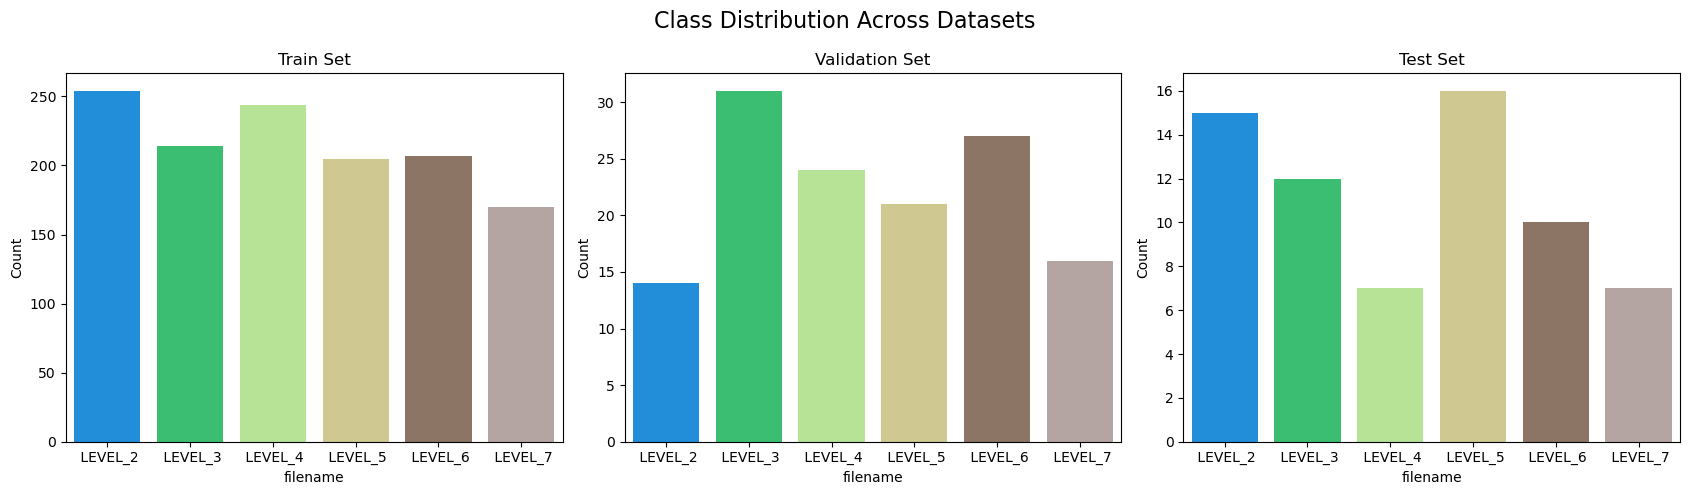

In [9]:
# Plot class distributions for train, validation, and test sets
fig, ax = plt.subplot_mosaic(
    mosaic=[[0, 1, 2]],
    figsize=(17, 5)
)
plot_value_counts(df_train, ax[0], 'Train Set')
plot_value_counts(df_val, ax[1], 'Validation Set')
plot_value_counts(df_test, ax[2], 'Test Set')
plt.suptitle('Class Distribution Across Datasets', fontsize=16)
plt.tight_layout()
plt.show()

**Findings**  
While the train set has balanced labels, both validation and test set don't, having the most common class more than twice the size of the rarest.

#### Image visualization

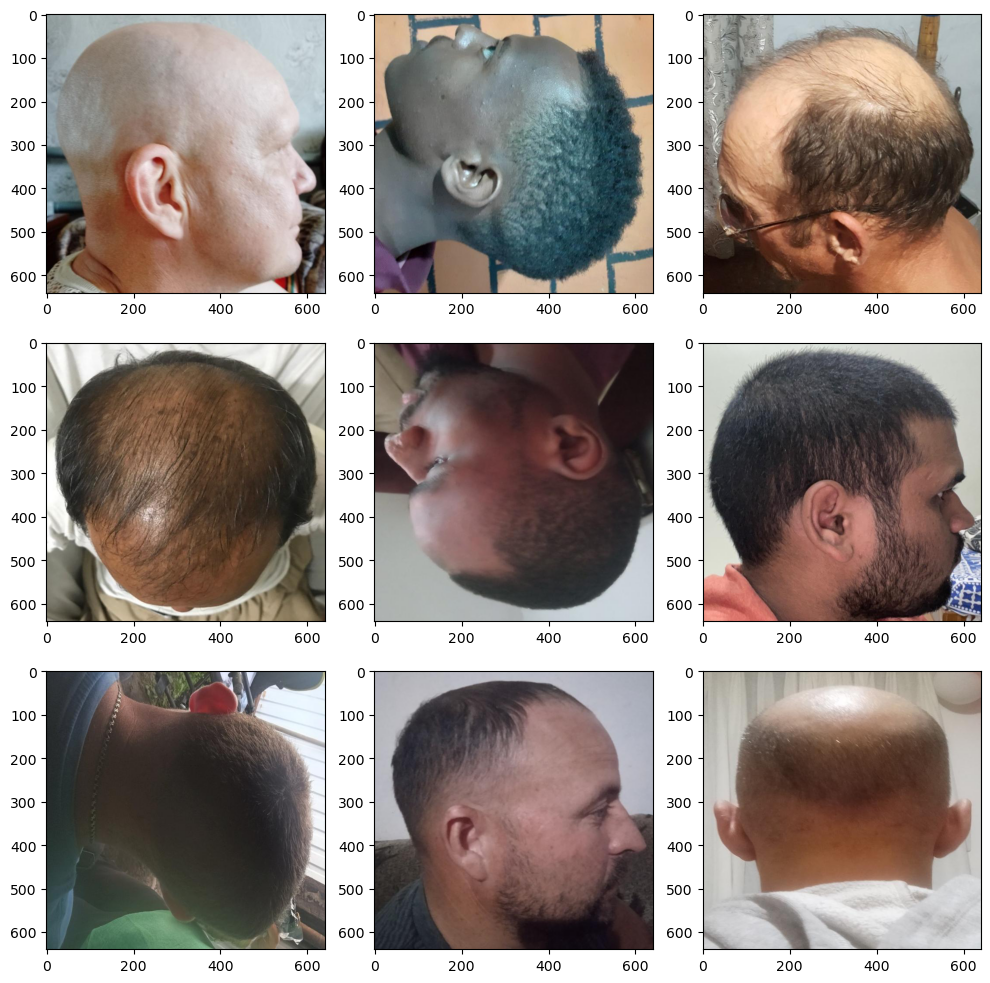

In [ ]:
# Display random images from the training set
num_images = 9
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
ax = ax.flatten()
for i in range(num_images):
    rand_num = np.random.randint(len(df_train))
    img = Image.open("src/data/train/" + df_train["filename"][rand_num])
    ax[i].imshow(img)

plt.tight_layout()
plt.show()

**Findings**  
Images from the training set had already been augmented by fliping them both horizontally and vertically

## Data processing

In [10]:
def undo_one_hot_encoding(df, num_categories=6, not_one_hot=['filename']):
    """
    Reconstructs a normalized continuous variable from one-hot encoded columns.

    This function processes a DataFrame containing one-hot encoded columns that represent ordinal categories 
    (e.g., severity levels, risk levels), and reconstructs a single continuous column named `level`. 
    It assumes the presence of one or more identifier columns (e.g., 'filename') 
    that are excluded from the decoding process.

    Parameters
    ----------
    df : pandas.DataFrame
        A DataFrame containing one-hot encoded columns and one or more identifier columns.
    num_categories : int, optional
        The total number of categories represented by the one-hot encoding. This value is used to normalize the 
        reconstructed level. Default is 6.
    not_one_hot : list of str, optional
        List of column names that should be excluded from the decoding process. These columns are copied directly 
        into the output DataFrame. Default is ['filename'].

    Returns
    -------
    df_undo : pandas.DataFrame
        A new DataFrame with the identifier columns and a reconstructed 'level' column:
        - Identifier columns: copied from the original DataFrame.
        - 'level': a continuous value reconstructed from the one-hot encoding.
    """
    
    # Create a new DataFrame to store the results and not mess up the original one
    df_undo = df[not_one_hot].copy()
    label_columns = df.columns.tolist()
    label_columns.remove('filename')
    # Find the index of the maximum value in each row and extract the level number
    df_undo['level'] = df[label_columns].idxmax(axis=1).str.extract('(\d)').astype(int) - 2
    # Normalize the level to the range [0, 1]
    df_undo['level'] = df_undo['level'] / (num_categories - 1)

    return df_undo

df_train= undo_one_hot_encoding(df_train)
df_val = undo_one_hot_encoding(df_val)
df_test = undo_one_hot_encoding(df_test)

df_train.level.unique()

array([1. , 0.4, 0.2, 0.8, 0. , 0.6])

In [ ]:
df_train.to_csv('src/data/train/df_train_one_hot.csv', index=False)
df_val.to_csv('src/data/valid/df_val_one_hot.csv', index=False)
df_test.to_csv('src/data/test/df_test_one_hot.csv', index=False)

In [189]:
# Transforms images from 640x640 to 224x224 tensors
to_tensor = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
# Creates a tensor stacking all training resized images
X_train_tensor = torch.stack([to_tensor(Image.open(f'src/data/train/{fname}')) for fname in df_train["filename"]]).squeeze()

# The extra dimension is needed for the loss function when training the model
y_train_tensor = torch.tensor(df_train['level'], dtype=torch.float32).unsqueeze(1)
X_train_tensor.size(), y_train_tensor.size()

(torch.Size([1294, 3, 224, 224]), torch.Size([1294, 1]))

In [ ]:
X_val_tensor = torch.stack([to_tensor(Image.open(f'src/data/valid/{fname}')).squeeze() for fname in df_val["filename"]])
y_val_tensor = torch.tensor(df_val['level'], dtype=torch.float32).unsqueeze(1)
X_val_tensor.size(), y_val_tensor.size()

(torch.Size([133, 3, 224, 224]), torch.Size([133, 1]))

In [ ]:
X_test_tensor = torch.stack([to_tensor(Image.open(f'src/data/test/{fname}')).squeeze() for fname in df_test["filename"]])
y_test_tensor = torch.tensor(df_test['level'], dtype=torch.float32).unsqueeze(1)
X_test_tensor.size(), y_test_tensor.size()

(torch.Size([67, 3, 224, 224]), torch.Size([67, 1]))

In [ ]:
# Save processed tensors
torch.save(X_train_tensor, 'src/data/train/X_train_data.pt')
torch.save(y_train_tensor, 'src/data/train/y_train_data.pt')
torch.save(X_val_tensor, 'src/data/valid/X_val_data.pt')
torch.save(y_val_tensor, 'src/data/valid/y_val_data.pt')
torch.save(X_test_tensor, 'src/data/test/X_test_data.pt')
torch.save(y_test_tensor, 'src/data/test/y_test_data.pt')

In [2]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Load tensors for training
X_train_tensor = torch.load('src/data/train/X_train_data.pt')
y_train_tensor = torch.load('src/data/train/y_train_data.pt')
X_val_tensor = torch.load('src/data/valid/X_val_data.pt')
y_val_tensor = torch.load('src/data/valid/y_val_data.pt')

X_train_tensor.shape, y_train_tensor.shape, X_val_tensor.shape, y_val_tensor.shape

(torch.Size([1294, 3, 224, 224]),
 torch.Size([1294, 1]),
 torch.Size([133, 3, 224, 224]),
 torch.Size([133, 1]))

In [26]:
# Create tensor dataset for data loader
Train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

Train_dataset[:][0].shape, Train_dataset[:][1].shape

(torch.Size([1294, 3, 224, 224]), torch.Size([1294, 1]))

In [17]:
Train_dataset[:5][1]

tensor([[1.0000],
        [0.4000],
        [0.2000],
        [0.8000],
        [0.0000]])

### Data Augmentation

Data augmentation pipeline.  
Includes random rotations, resized crops, equalization, saturation, hue, contrast, brightness adjustments,
and normalization to improve model generalization.

In [18]:
# Data augmentation pipeline.
augment = torch.nn.Sequential(
    K.RandomRotation(degrees=(-22.5, 22.5), p=0.5),
    K.RandomResizedCrop(size=(224, 224), scale=(0.7, 1), ratio=(0.9, 1.1), p= 0.6),
    K.RandomEqualize(p=0.6),
    K.RandomGaussianNoise(mean=0, std=0.075, p=0.33),
    K.RandomSaturation(saturation=(0.75, 1.25), p=0.5),
    K.RandomHue(hue=(-0.01, 0.01), p=0.8),
    K.RandomContrast(contrast=(0.8, 1.2), p=0.7),
    K.RandomBrightness(brightness=(0.8, 1.1), p=0.7),
    K.RandomPerspective(distortion_scale=0.2, p=0.33),
    K.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

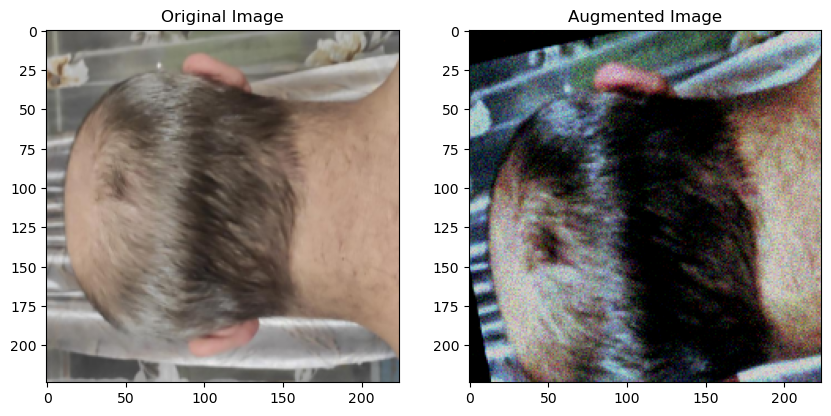

In [9]:
# Sample a random image from the training dataset and apply augmentation
rand_num = np.random.randint(len(Train_dataset))
img = Train_dataset[rand_num][0]
img_aug = augment(img)

# Remove batch dimension
img_aug = img_aug.squeeze()

# Denormalize for visualization
denormalize = K.Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img_aug_denorm = denormalize(img_aug)

# Permute dimensions for visualization
img_aug_permuted = img_aug_denorm[0].permute(1, 2, 0).numpy()
img_permuted = img.permute(1, 2, 0).numpy()  

# Clip values to [0, 1] range for proper display
img_aug_cliped = np.clip(img_aug_permuted, 0, 1)
img_cliped = np.clip(img_permuted, 0, 1)

# Display original and augmented images side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_cliped)
ax[1].imshow(img_aug_cliped)
ax[0].set_title('Original Image')
ax[1].set_title('Augmented Image')

plt.show()


## Model Architecture & Initialization

### Model selection

MaxViT_t provides efficient multi‑axis attention combined with convolutional inductive biases, making it a suitable pretrained backbone for transfer learning in vision tasks. Futhermore the tiny version provides the best accuracy-FLOPs ratio in ImageNet1K, reaching an accuracy of ~83.5% with just 1.6 GFLOPs [[2](#references)], given the limited equipment this metric was cosidered crucial.

In [5]:
def build_maxvit_t():
    """
    Constructs and customizes a MaxViT-T model for regression tasks.

    This function loads a pretrained MaxViT-T model using ImageNet-1K weights, applies selective freezing 
    and dropout adjustments, and modifies the final classification layer to output a single continuous value 
    suitable for regression.

    Parameters
    ----------
    None

    Returns
    -------
    model : torch.nn.Module
        A modified MaxViT-T model with:
        - Pretrained weights from ImageNet-1K.
        - Frozen parameters in the first block (`model.blocks[0]`).
        - Dropout rate set to 0.5 in all Dropout layers outside the frozen block.
        - Final classifier layer replaced with a linear layer outputting a single value instead of the 1000 classes of ImageNet-1K.
    """

    weights = MaxVit_T_Weights.IMAGENET1K_V1
    model = maxvit_t(weights=weights)
    
    # Freeze the parameters of the first block
    for param in model.blocks[0].parameters():
        param.requires_grad = False
    
    # Set dropout rate to 0.5 in all Dropout layers except the first block which is frozen
    for module in model.blocks[1:].modules():
        if isinstance(module, nn.Dropout):
            module.p = 0.5         

    # Modify the final layer to output a single value for regression
    in_features = model.classifier[-1].in_features # 512
    model.classifier[-1] = nn.Sequential(
        nn.Linear(in_features, 1),
        nn.Sigmoid() # To ensure output is between 0 and 1
    )

    return model

In [6]:
Model = build_maxvit_t()
summary(Model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                                                                Output Shape              Param #
MaxVit                                                                                [32, 1]                   --
├─Sequential: 1-1                                                                     [32, 64, 112, 112]        --
│    └─Conv2dNormActivation: 2-1                                                      [32, 64, 112, 112]        --
│    │    └─Conv2d: 3-1                                                               [32, 64, 112, 112]        1,728
│    │    └─BatchNorm2d: 3-2                                                          [32, 64, 112, 112]        128
│    │    └─GELU: 3-3                                                                 [32, 64, 112, 112]        --
│    └─Conv2dNormActivation: 2-2                                                      [32, 64, 112, 112]        --
│    │    └─Conv2d: 3-4                                                

## Training Loop

### Hyperparameters Selection
Training values where extracted from the MaxVit paper, table 12 in "Experimental Settings" section [[3](#references)].   
However due to hardware limitations and slightly different task, batch size and loss function where changed.

### Loss function
Framing the ordinal target as a continuous scalar enables backpropagation of more precise and logically consistent errors, as the order between classes is preserved.

To evaluate this approach, five different loss functions were tested. Since the task is ordinal classification, decompositional ordinal methods such as CORAL and CORN [[4](#references)] were initially considered as well as the traditional choice for this kind of problem, CrossEntropy. However, both yielded poor results and significantly longer training times compared to regression-based losses.

Among the regression losses, L1Loss (MAE), MSELoss, and HuberLoss ($\delta$=1) were evaluated. All three performed similarly in terms of training dynamics and evaluation metrics, but L1Loss demonstrated superior generalization overall.

In [ ]:
def train_model(model, train_dataset, X_tensor_val, y_tensor_val, epochs=500, batch_size=32, learning_rate=5e-5, scheduler=False, scheduler_patience=50, early_stopping=True, early_stopping_patience=50, smooth=True, show=True):
    """
    Train a PyTorch model using mixed precision, optional EMA smoothing, learning-rate scheduling, and early stopping.

    Parameters
    ----------
    model : torch.nn.Module
        The model to train. The model is moved to a device referenced by the global variable `device`.
    train_dataset : torch.utils.data.Dataset or torch.utils.data.TensorDataset
        Dataset used for training. Batches are drawn with a reproducible Generator seeded inside the function.
    X_tensor_val : torch.Tensor
        Validation feature tensor used for early-stopping evaluation. Sent to `device` when `early_stopping` is True.
    y_tensor_val : torch.Tensor
        Validation label tensor corresponding to `X_tensor_val`. Sent to `device` when `early_stopping` is True.
    epochs : int, optional
        Maximum number of training epochs. Default is 500.
    batch_size : int, optional
        Batch size for the training DataLoader. Default is 32.
    learning_rate : float, optional
        Initial learning rate passed to the AdamW optimizer. Default is 5e-5.
    scheduler : bool, optional
        If True, a StepLR scheduler is created and stepped each epoch. Default is False.
    scheduler_patience : int, optional
        Step size (in epochs) passed to StepLR when `scheduler` is True. Default is 50.
    early_stopping : bool, optional
        If True, validation loss is monitored and training may stop early when no improvement is observed. Default is True.
    early_stopping_patience : int, optional
        Number of consecutive epochs without improvement on the validation loss required to trigger early stopping. Default is 50.
    smooth : bool, optional
        If True, an EMA wrapper is used to maintain a smoothed copy of model weights during training. Default is True.
    show : bool, optional
        If True, periodic progress and validation metrics are printed to stdout. Default is True.

    Returns
    -------
    model : torch.nn.Module
        The trained model. If early stopping was used, the function restores and returns the state corresponding to the best observed validation loss.

    Behavior and Implementation Details
    -----------------------------------
    - The function seeds PyTorch (`torch.manual_seed(SEED)`) and the DataLoader generator for reproducibility.
    - The model is moved to the global `device`. When `early_stopping` is enabled, validation tensors are moved to `device`.
    - Optimizer: AdamW with the provided `learning_rate` and a small weight decay (1e-8).
    - Loss: L1 loss (mean absolute error) is used as the training and validation criterion.
    - Mixed precision: training uses AMP via `autocast` and a `GradScaler` for stable FP16 updates.
    - EMA smoothing: when `smooth` is True, an `EMA` instance is created and updated after each optimizer step; evaluation uses the EMA copy if available.
    - Data loading: DataLoader is created with `shuffle=True`, a deterministic `Generator` seed, and `pin_memory=True`.
    - Augmentation: each training batch and the validation input passed to the evaluation step are transformed with an `augment` function expected to exist in the calling scope.
    - Scheduler: if `scheduler` is True, a StepLR scheduler with `step_size=scheduler_patience` and `gamma=0.85` is stepped each epoch.
    - Early stopping: when enabled, the function evaluates the model (or EMA model) on the validation tensors each epoch, tracks the best validation loss, saves the best model state_dict, and stops training if no improvement is seen for `early_stopping_patience` consecutive epochs; on early stop the best state is restored before returning the model.

    Notes
    -----
    - The function assumes the existence of the following names in the surrounding scope: `device`, `augment`, `EMA`, and relevant imports for `torch`, `optim`, `nn`, `GradScaler`, and `autocast`.
    - The final returned model is the model with parameters restored to the best validation snapshot if early stopping occurred, otherwise it is the last trained state.
    - The function prints periodic training statistics when `show` is True; printing frequency is every 10 epochs in the provided implementation.
    """

    # Seed for reproducibility
    torch.manual_seed(SEED)

    # Move model and validation tensors to device
    model = model.to(device)
    if early_stopping:
        X_tensor_val = X_tensor_val.to(device)
        y_tensor_val = y_tensor_val.to(device)

    # Define optimizer, loss function, and scaler for mixed precision
    optimizer = optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=1e-8            
    )

    criterion = nn.L1Loss()

    scaler = GradScaler()

    # EMA smoothing
    if smooth:
        ema = EMA(
            model,
            beta=0.9999,
            update_after_step=0,
            update_every=1
        )

    # Learning rate scheduler
    if scheduler:
        step_lr = optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=scheduler_patience, 
                                            gamma=0.85)
    # Early stopping variables
    if early_stopping:
        best_val_loss = float('inf')
        epochs_without_improvement = 0
        best_model = None

    # DataLoader with reproducible shuffling
    generator = torch.Generator()
    generator.manual_seed(SEED)

    # Create DataLoader for training
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        generator=generator,
        pin_memory=True
    )

    # Training loop
    for epoch in range(epochs):

        if show:
            total_loss = 0.0

        # Set model to training mode
        model.train()

        # load batches
        for x_batch, y_batch in train_loader:

            # Apply augmentation
            x_batch = augment(x_batch)
            x_batch = x_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass with mixed precision
            with autocast(device_type=device.type):
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)

            # Accumulate loss for reporting
            if show:
                total_loss += loss.item()

            # Backward pass and optimization step with mixed precision
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # EMA update
            if smooth:
                ema.update()

        # Step the learning rate scheduler
        if scheduler:
            step_lr.step()
        
        # Evaluate the EMA model if smoothing is enabled
        model_eval = ema.ema_model if smooth else model

        # Early stopping evaluation
        if early_stopping:

            # Set model to evaluation mode
            model_eval.eval()

            # Set inference mode for model evaluation
            with torch.inference_mode():
                val_outputs = model_eval(X_tensor_val)
                val_loss = criterion(val_outputs, y_tensor_val)
           
            # Check for improvement
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                epochs_without_improvement = 0
                best_model = model_eval.state_dict()
            else:
                epochs_without_improvement += 1

                # Check for early stopping condition
                if epochs_without_improvement >= early_stopping_patience:
                    if show:
                        print(f'No improvement observed in {early_stopping_patience} epochs. Stopping training.')

                    # Restore the model state with the best validation loss
                    model.load_state_dict(best_model)
                    return model

        # Print training progress
        if show and ((epoch + 1) % 25 == 0 or epoch == 0):
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}')
            if early_stopping:
                print(f'Best validation loss:{best_val_loss:.4f}')
                print(f'Current validation loss:{val_loss.item():.4f}')
                print("-" * 30)

    # If early stopping was used and it didn't trigger return the model with the best validation loss anyway
    if early_stopping and best_model:
        model.load_state_dict(best_model)

    return model


In [24]:
# Check GPU memory usage for training
print(torch.cuda.memory_allocated())

132907520


In [27]:
# Training
Model = train_model(Model, Train_dataset, X_val_tensor, y_val_tensor)

Epoch [1/500], Loss: 0.2314
Best validation loss:0.2257
Current validation loss:0.2257
------------------------------
Epoch [25/500], Loss: 0.0757
Best validation loss:0.0982
Current validation loss:0.0982
------------------------------
Epoch [50/500], Loss: 0.0452
Best validation loss:0.0863
Current validation loss:0.0876
------------------------------
Epoch [75/500], Loss: 0.0355
Best validation loss:0.0788
Current validation loss:0.0817
------------------------------
Epoch [100/500], Loss: 0.0281
Best validation loss:0.0764
Current validation loss:0.0766
------------------------------
Epoch [125/500], Loss: 0.0225
Best validation loss:0.0759
Current validation loss:0.0777
------------------------------
Epoch [150/500], Loss: 0.0186
Best validation loss:0.0757
Current validation loss:0.0788
------------------------------
Epoch [175/500], Loss: 0.0158
Best validation loss:0.0717
Current validation loss:0.0717
------------------------------
Epoch [200/500], Loss: 0.0133
Best validation

In [8]:
mlflow.pytorch.log_model(Model, name="MaxVit_T_Sigmoid")

2025/12/04 15:54:04 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/04 15:54:17 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.22.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torchvision==0.22.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/04 15:54:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Model Evaluation

In [9]:
# Normalization, the saved tensors are not normalized yet
normalize = K.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def evaluate_model(y_eval, logits_pred, num_categories=6):
    """
    Evaluates model predictions against true labels using classification metrics and visualizations.

    This function compares predicted logits to true labels by rescaling, rounding, and one-hot encoding.
    It computes accuracy, mean absolute percentage error (MAPE), and a classification report, and displays
    a confusion matrix and error distribution plot.

    Parameters
    ----------
    y_eval : torch.Tensor
        Ground truth labels as a 1D tensor, expected to be normalized in the range [0, 1].

    logits_pred : torch.Tensor
        Model output logits as a 1D tensor, also normalized in the range [0, 1].

    num_categories : int, optional
        The number of discrete categories/classes in the target variable. Default is 6.

    Returns
    -------
    None
        The function prints evaluation metrics and displays visualizations. It does not return any value.

    Notes
    -----
    - Both `y_eval` and `logits_pred` are rescaled to the original range using: `value * num_categories`.
    - Predictions are clipped to the range [1, num_categories] and rounded to the nearest integer.
    - One-hot encoding is applied to both true and predicted labels for multi-class evaluation.
    - The classification report is computed using `sklearn.metrics.classification_report`.
    - Accuracy is computed as the proportion of exact matches between rounded predictions and labels.
    - Mean Absolute Error (MAE) is calculated as the average absolute difference between predictions and true labels.
    - Mean Absolute Percentage Error (MAPE) is calculated using the absolute error divided by the mean of true values.
    - Quadratic Cohen's Kappa is computed to assess the agreement between true and predicted labels.
    - A confusion matrix heatmap and a KDE plot of prediction error are displayed.
    - Bootstrap resampling (10,000 samples) is used to estimate the mean, non parametric standard error, and 95% confidence intervals for the metrics.
    """

    # Formatting tensors to numpy arrays
    y_eval = y_eval.view(-1).detach().cpu().numpy()
    logits_pred = logits_pred.view(-1).detach().cpu().numpy()

    # Rescaling values back to original range and adding 1 to avoid division by zero in MAPE
    y_eval = y_eval * (num_categories - 1) + 1
    logits_pred = logits_pred * (num_categories - 1) + 1

    # Rounding to nearest integer
    y_pred = np.round(logits_pred).astype(int)
    y_eval = np.round(y_eval).astype(int)

    # Bootstrap
    n_samples = 10000
    rng = np.random.default_rng(seed=SEED)
    accuracies = []
    maes = []
    mapes = []
    kappa_scores = []
  
    for _ in range(n_samples):
        indexes = rng.choice(np.arange(len(y_eval)), size=len(y_eval), replace=True)
        logits_pred_sample = logits_pred[indexes]
        y_eval_sample = y_eval[indexes]
        y_pred_sample = y_pred[indexes]
        accuracies.append(np.mean(y_pred_sample == y_eval_sample))
        maes.append(np.mean(np.abs(logits_pred_sample - y_eval_sample)))
        mapes.append(np.mean(np.abs(logits_pred_sample - y_eval_sample) / (y_eval_sample)) * 100)
        kappa_scores.append(cohen_kappa_score(y_eval_sample, y_pred_sample, weights='quadratic'))
    
    # Bootstrap results
    print(f'Bootstrap results: mean ± standard error | 95% Confidence Interval over {n_samples} samples')
    print(f'Accuracy: {np.mean(accuracies):.2f} ± {np.std(accuracies):.2f} | CI: [{np.percentile(accuracies, 2.5):.2f} - {np.percentile(accuracies, 97.5):.2f}]')
    print(f'Mean Absolute Error: {np.mean(maes):.2f} ± {np.std(maes):.2f} | CI: [{np.percentile(maes, 2.5):.2f} - {np.percentile(maes, 97.5):.2f}]')
    print(f'Mean Absolute Percentage Error: {np.mean(mapes):.2f} ± {np.std(mapes):.2f} | CI: [{np.percentile(mapes, 2.5):.2f} - {np.percentile(mapes, 97.5):.2f}]')
    print(f'Quadratic Cohen\'s Kappa: {np.mean(kappa_scores):.2f} ± {np.std(kappa_scores):.2f} | CI: [{np.percentile(kappa_scores, 2.5):.2f} - {np.percentile(kappa_scores, 97.5):.2f}]')

    # Confusion Matrix
    cm = confusion_matrix(y_eval, y_pred)
    #error = y_eval - logits_pred
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest', ax=ax[0])
    ax[0].set_xlabel('Prediction')
    ax[0].set_ylabel('Real')
    ax[0].set_title('Confusion Matrix')
    sns.kdeplot(maes, ax=ax[1], color='navy', fill=True)
    ax[1].axvline(x=np.mean(maes), color='red', linestyle='--', label='Mean')
    ax[1].axvline(x=np.percentile(maes, 2.5), color='green', linestyle='--', label='CI 95%')
    ax[1].axvline(x=np.percentile(maes, 97.5), color='green', linestyle='--')

    mae_density = gaussian_kde(maes)
    mae_density_curve = mae_density(np.linspace(np.min(maes), np.max(maes), 20))
    ax[1].text(np.percentile(maes, 2.5) - np.std(mapes) * 0.02, np.max(mae_density_curve), '2.5%', color='green')
    ax[1].text(np.percentile(maes, 97.5) + np.std(mapes) * 0.0025, np.max(mae_density_curve), '97.5%', color='green')
    ax[1].set_title('Bootstrap Mean Absolute Error Distribution')
    ax[1].legend()
    plt.show()

    return np.mean(accuracies), np.mean(maes), np.mean(mapes), np.mean(kappa_scores)

Bootstrap results: mean ± standard error | 95% Confidence Interval over 10000 samples
Accuracy: 0.75 ± 0.05 | CI: [0.64 - 0.85]
Mean Absolute Error: 0.31 ± 0.05 | CI: [0.20 - 0.41]
Mean Absolute Percentage Error: 11.40 ± 2.40 | CI: [7.03 - 16.39]
Quadratic Cohen's Kappa: 0.95 ± 0.02 | CI: [0.91 - 0.97]


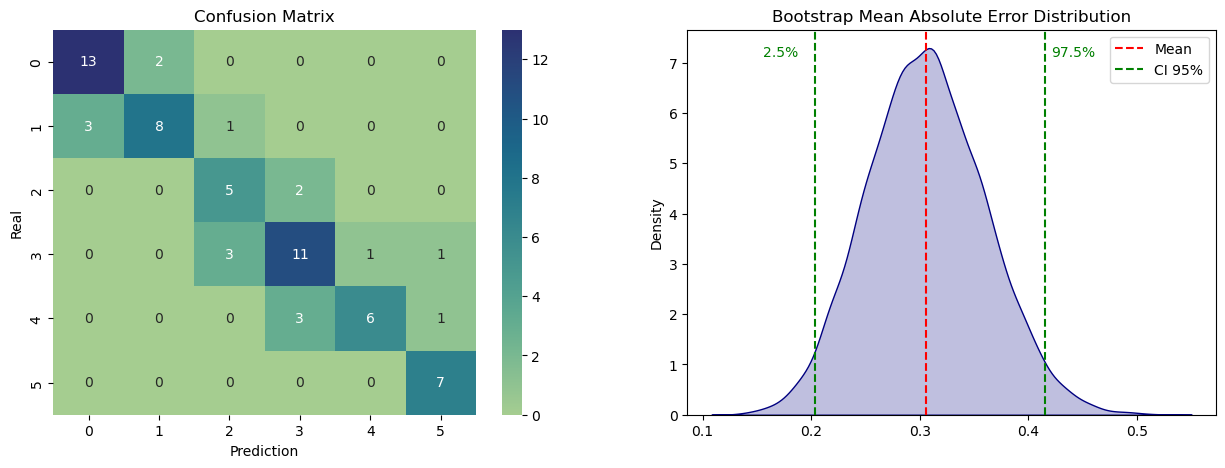

In [ ]:
# Load test tensors
X_test_tensor = torch.load('src/data/test/X_test_data.pt').to(device)
y_test_tensor = torch.load('src/data/test/y_test_data.pt').to(device)

# Normalize test data
X_test_tensor = normalize(X_test_tensor)

# Get model test predictions
with torch.inference_mode():
    Model.eval()
    logits_test = Model(X_test_tensor)

# Evaluate model performance on test set
test_accuracy, test_mae, test_mape, test_kappa = evaluate_model(y_eval=y_test_tensor, logits_pred=logits_test)
mlflow.log_metric("Test Accuracy", test_accuracy)
mlflow.log_metric("Test MAE", test_mae)
mlflow.log_metric("Test MAPE", test_mape)
mlflow.log_metric("Test Quadratic Kappa", test_kappa)

# Clear memory
del X_test_tensor, y_test_tensor, logits_test
torch.cuda.empty_cache()

**Findings**  
The model demonstrates robust classification performance, with an average accuracy of 75% and a high inter-rater agreement, indicating strong consistency across ordinal predictions.   
The error metrics suggest low deviation and minimal relative bias, supporting its reliability for practical deployment. This performance is uneven across classes, with a poor recall in class 2, suggesting insufficient feature discrimination for middle classes.

Bootstrap results: mean ± standard error | 95% Confidence Interval over 10000 samples
Accuracy: 0.74 ± 0.04 | CI: [0.66 - 0.81]
Mean Absolute Error: 0.32 ± 0.05 | CI: [0.23 - 0.41]
Mean Absolute Percentage Error: 12.92 ± 3.02 | CI: [7.90 - 19.57]
Quadratic Cohen's Kappa: 0.92 ± 0.02 | CI: [0.88 - 0.95]


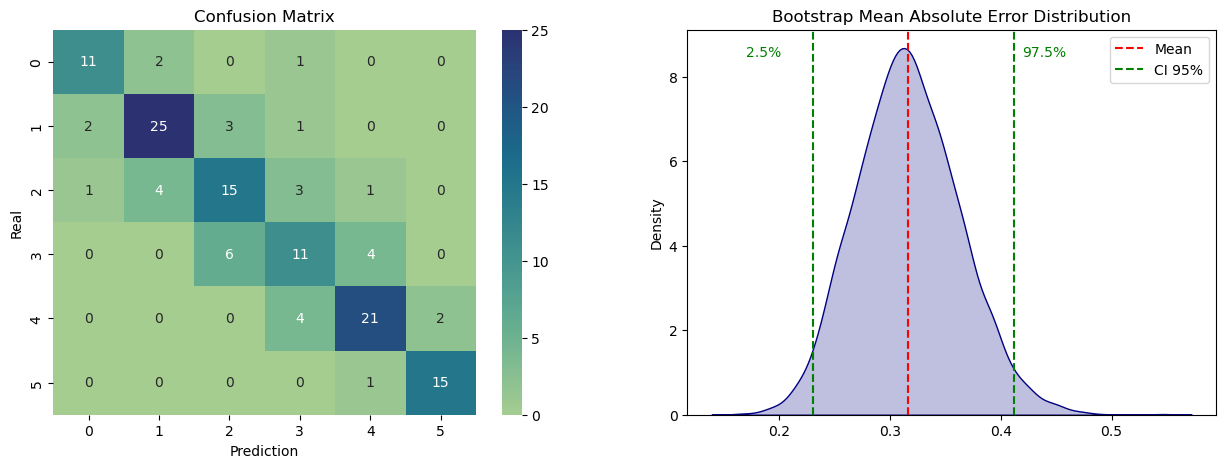

In [ ]:
# Load validation tensors
X_val_tensor = torch.load('src/data/valid/X_val_data.pt').to(device)
y_val_tensor = torch.load('src/data/valid/y_val_data.pt').to(device)

X_val_tensor = normalize(X_val_tensor)

with torch.inference_mode():    
    Model.eval()
    logits_val = Model(X_val_tensor)

val_accuracy, val_mae, val_mape, val_kappa = evaluate_model(y_eval=y_val_tensor, logits_pred=logits_val)
mlflow.log_metric("Validation Accuracy", val_accuracy)
mlflow.log_metric("Validation MAE", val_mae)
mlflow.log_metric("Validation MAPE", val_mape)
mlflow.log_metric("Validation Quadratic Kappa", val_kappa)

# Clear memory
del X_val_tensor, y_val_tensor, logits_val
torch.cuda.empty_cache()

**Findings**  
The model achieves moderate classification performance, with a substantial agreement across ordinal categories.   
The confusion matrix shows more normaly distributed erros adyacent to the diagonal but still giving good results.  
Very similar to the test set.

Bootstrap results: mean ± standard error | 95% Confidence Interval over 10000 samples
Accuracy: 1.00 ± 0.00 | CI: [1.00 - 1.00]
Mean Absolute Error: 0.02 ± 0.00 | CI: [0.02 - 0.02]
Mean Absolute Percentage Error: 0.71 ± 0.02 | CI: [0.67 - 0.74]
Quadratic Cohen's Kappa: 1.00 ± 0.00 | CI: [1.00 - 1.00]


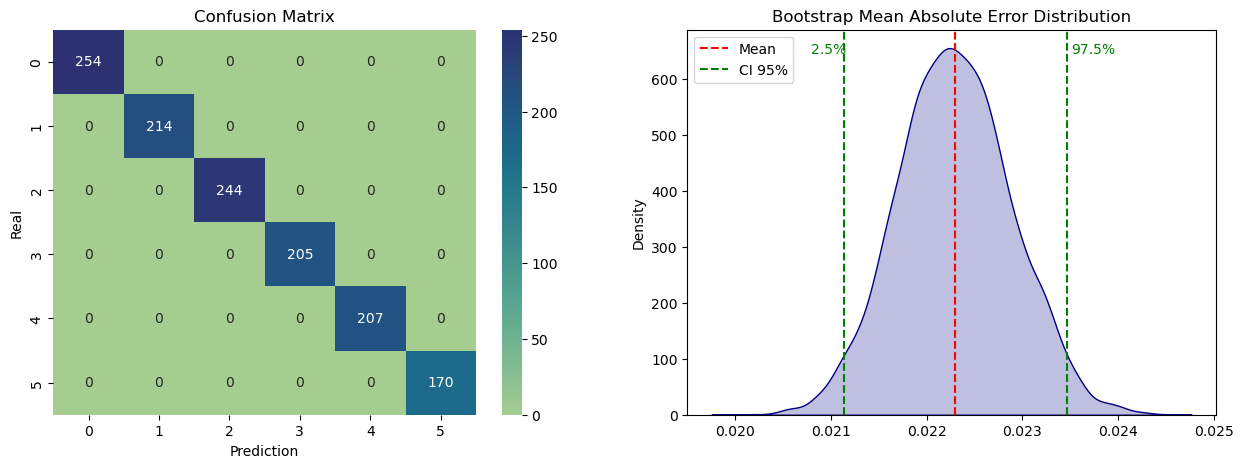

In [ ]:
# Load training tensors
X_train_tensor = torch.load('src/data/train/X_train_data.pt')
y_train_tensor = torch.load('src/data/train/y_train_data.pt')

# Normalize training data
X_train_tensor = normalize(X_train_tensor)

# Create DataLoader for training data since it does not fit in memory all at once
Train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(Train_dataset, batch_size=512, shuffle=False)

# Get model training predictions in batches
logits_train = torch.tensor([]).to(device)

for x_batch, y_batch in train_loader:
    with torch.inference_mode():
        logits = Model(x_batch.to(device))
        logits_train = torch.cat((logits_train, logits), dim=0)

train_accuracy, train_mae, train_mape, train_kappa = evaluate_model(y_eval=y_train_tensor, logits_pred=logits_train)
mlflow.log_metric("Train Accuracy", train_accuracy)
mlflow.log_metric("Train MAE", train_mae)
mlflow.log_metric("Train MAPE", train_mape)
mlflow.log_metric("Train Quadratic Kappa", train_kappa)

# Clear memory even if is not needed anymore in this notebook, this pc is still used on other tasks
del X_train_tensor, y_train_tensor, logits_train
torch.cuda.empty_cache()

**Findings**  
The training set metrics are effectively perfect which indicates extreme overfitting

In [15]:
run_id = mlflow.active_run().info.run_id
mlflow.register_model("runs:/{}/MaxVit_T_Sigmoid".format(run_id), "Alopecia Classifier")

Successfully registered model 'Alopecia Classifier'.
2025/12/04 15:56:43 WARNING mlflow.tracking._model_registry.fluent: Run with id bb71cef6552e45dfaa59a5a99f6ad78c has no artifacts at artifact path 'MaxVit_T_Sigmoid', registering model based on models:/m-36ceb78029984eefbadd38d439c75514 instead
2025/12/04 15:56:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Alopecia Classifier, version 1
Created version '1' of model 'Alopecia Classifier'.


<ModelVersion: aliases=[], creation_timestamp=1764860203860, current_stage='None', deployment_job_state=<ModelVersionDeploymentJobState: current_task_name='', job_id='', job_state='DEPLOYMENT_JOB_CONNECTION_STATE_UNSPECIFIED', run_id='', run_state='DEPLOYMENT_JOB_RUN_STATE_UNSPECIFIED'>, description='', last_updated_timestamp=1764860203860, metrics=None, model_id=None, name='Alopecia Classifier', params=None, run_id='bb71cef6552e45dfaa59a5a99f6ad78c', run_link='', source='models:/m-36ceb78029984eefbadd38d439c75514', status='READY', status_message=None, tags={}, user_id='', version='1'>

In [16]:
mlflow.end_run()

🏃 View run Maxvit-sigmoid at: http://localhost:5000/#/experiments/1/runs/bb71cef6552e45dfaa59a5a99f6ad78c
🧪 View experiment at: http://localhost:5000/#/experiments/1


#### Overall evaluation 

The model produces competitive results with Quadratic Cohen's Kappa scores above 0.92 ± 0.02, but exhibits clear generalization gaps relative to the training partition, which is almost perfect.  
Per-class diagnostics show that middle ordinal levels suffer more false positives/negatives (borderline ambiguity), while extreme classes (classes 6 and 0) are easier for the model.  
Test and validation sets show consistency, hence the model demonstrates robustness ergo lowering the risk of its usage in future data.  
Given the perfect train scores vs. substantially lower validation/test performance with an aggressive dropout rate (0.5) and random data augmentation during training indicates a lack of training examples (465 unique examples pre augmentation).

## Conclusion

**Executive summary**     

This project implements an end-to-end pipeline for automated grading of androgenetic alopecia using transfer learning on a MaxViT backbone.  
The approach treats the task as continuous regression with post-hoc calibration to the original ordinal scale, providing both regression and classification perspectives on model performance.  

- Dataset and scope: Experiments use the publicly available hair-loss dataset (train / val / test splits). The analysis emphasizes data integrity checks, class-distribution inspection and reproducible preprocessing.  
- Methodology: Images are preprocessed and augmented (Kornia); a pre-trained MaxViT model is adapted for a single continuous output; training applies mixed precision and EMA smoothing; predictions are clipped and discretized for ordinal evaluation.  
- Evaluation protoco: Model quality is assessed with continuous metrics (MAE/MSE) and ordinal classification metrics (Accuracy, Quadratic Weighted Kappa), supplemented by confusion matrices and per-class error analysis. 
- Principal finding: The MaxViT-based pipeline demonstrates strong representational capacity and yields competitive performance on held-out data when judged by both regression and ordinal metrics; most errors occur at adjacent ordinal levels (boundary cases), indicating sensible model behaviour for an ordinal task.  
- Practical implication: The hybrid regression -> discretisation strategy provides a robust, interpretable compromise when direct ordinal losses are unstable in practice, but success depends critically on careful threshold calibration with enough training data for the model to not get perfect metrics.  

**Key findings**

- Modeling approach: Training as a continuous regression with post-hoc discretisation is a pragmatic and defensible solution when direct ordinal methods (e.g., CORAL/CORN) fail in practice. It yields both continuous error measures (MAE/MSE) and discrete classification metrics after calibration.  
- Performance characteristics: The model demonstrates good capacity to fit training data, but the risk of overfitting remains given the effective number of unique examples and the heavy augmentations and dropout used for regulation purposes.
- Since both test and validation sets show similar metrics the modes suggests robustness.

**Limitations**

- Dataset size: The number of unique, labelled images is very limited. 
- Representativeness: Augmentation mitigates but does not replace real diversity. External generalisability is untested, furthermore it only uses male short haired subjects with a male hair loss pattern, ergo long hair subjects or female hair loss patterns are out of the model's scop.   

## References

 1. “hair-loss Classification Model by uze,” Roboflow, Jun. 19, 2024. https://universe.roboflow.com/uze/hair-loss-nq8hh.  [1](#deep-learning-based-ordinal-classification-of-androgenetic-alopecia-severity-through-transfer-learning-with-maxvit) 
 2. Z. Tu et al., “MaxVIT: Multi-Axis Vision Transformer,” arXiv.org, Apr. 04, 2022. https://arxiv.org/abs/2204.01697  [2](#model-selection), [3](#hyperparameters-selection)  
 3. X. Shi, W. Cao, and S. Raschka, “Deep neural networks for rank-consistent ordinal regression based on conditional probabilities,” Pattern Analysis and Applications, vol. 26, no. 3, pp. 941–955, Jun. 2023, doi: 10.1007/s10044-023-01181-9. [4](#loss-function)
